- 스킵구조를 이용한 CNN 신경망
  - 은닉층을 거지치치않은 입력값과 은닉층의 결과를 합치는 구조
- 기울기 소실
  - 층이 많이질수록 가중치의 기울기들 0에 가까워지는 현상
- 배치정규화
  - 배치간의 차이를 정규화해서 더 안정적인 학습


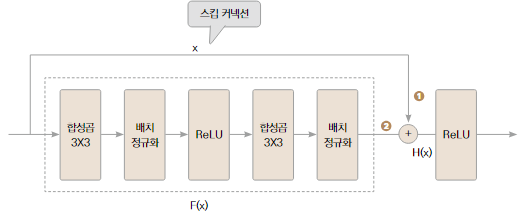

In [1]:
#ResNet 기존 블럭
import torch
import torch.nn as nn

In [26]:
class BasicBlock(nn.Module):
  def __init__(self, in_channel,out_channel,kernel_size=3):
    super(BasicBlock,self).__init__()
    # 합성곱층
    self.c1 = nn.Conv2d(in_channel,out_channel,kernel_size=kernel_size,padding=1)
    self.c2 = nn.Conv2d(out_channel,out_channel,kernel_size=kernel_size,padding=1)

    self.downsample = nn.Conv2d(in_channel,out_channel,kernel_size=1)

    # 배치정규화
    self.bn1 = nn.BatchNorm2d(num_features = out_channel)
    self.bn2 = nn.BatchNorm2d(num_features = out_channel)

    self.relu = nn.ReLU()
  def forward(self,x):
    # 스킵커넥션을 위해 초기 입력 저장
    x_ = x
    # 기본블럭
    x = self.c1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.c2(x)
    x = self.bn2(x)
    # 합성곱의 결과와 입력 채널수를 맞춤
    x_ = self.downsample(x_)
    # 합성곱의 결과와 미리저장한 입력값을 더해줌
    x += x_
    x = self.relu(x)
    return x

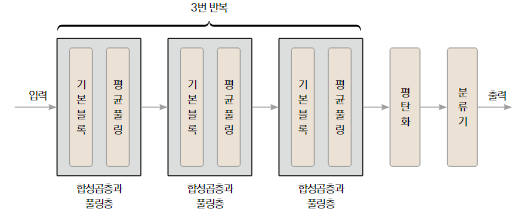

In [27]:
class ResNet(nn.Module):
  def __init__(self, num_classes = 10) -> None:
    super(ResNet,self).__init__()

    # 기본블럭
    self.b1 = BasicBlock(3,64)
    self.b2 = BasicBlock(64,128)
    self.b3 = BasicBlock(128,256)

    # 폴링을 평균폴링으로
    self.pool = nn.AvgPool2d(2,2)

    # 분류기 fc
    self.fc1 = nn.Linear(in_features=4096, out_features=2048)
    self.fc2 = nn.Linear(in_features=2048, out_features=512)
    self.fc3 = nn.Linear(in_features=512, out_features=num_classes)

    self.relu = nn.ReLU()
  def forward(self,x):
    x = self.b1(x)
    x = self.pool(x)
    x = self.b2(x)
    x = self.pool(x)
    x = self.b3(x)
    x = self.pool(x)
    x = torch.flatten(x,start_dim=1)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    return x

In [4]:
import matplotlib.pyplot as plt
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor, Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Normalize
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

In [5]:
transforms = Compose([
    RandomCrop( (32,32),padding=4),
    RandomHorizontalFlip(p=0.5),
    ToTensor(),
    Normalize(mean = (0.5,0.5,0.5), std = (0.2,0.2,0.2))
])

In [6]:
training_data =  CIFAR10(     root='./', train=True,download=True,transform=ToTensor() )
test_data =  CIFAR10(     root='./', train=False,download=True,transform=ToTensor() )
train_loader = DataLoader(training_data,batch_size=32,shuffle=True)
test_loader = DataLoader(test_data,batch_size=32,shuffle=False)

100%|██████████| 170498071/170498071 [00:14<00:00, 11469900.98it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet()
model.to(device)

ResNet(
  (b1): BasicBlock(
    (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (b2): BasicBlock(
    (c1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (b3): BasicBlock(
    (c1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [29]:
optim = Adam(model.parameters(), lr=0.001)
from tqdm import tqdm
for epoch in range(5):
  iter = tqdm(train_loader)
  for data,label in iter:
    optim.zero_grad()
    preds = model(data.to(device))
    loss = nn.CrossEntropyLoss()(preds,label.to(device))
    loss.backward()
    optim.step()

    iter.set_description(f"epoch:{epoch} loss:{loss.item()}")
torch.save(model.state_dict(),"ResNet.pth")


epoch:4 loss:0.8261603713035583: 100%|██████████| 1563/1563 [00:32<00:00, 48.75it/s]


In [30]:
# 모델 불러오기
model.load_state_dict(torch.load('ResNet.pth', map_location = device))
num_corr = 0 # 실제 맞춘계수
with torch.no_grad():  # 평가는 역전파 안함
  for data,label in test_loader:
    output =  model(data.to(device)) # 데이터를 device 로드
    preds = output.data.max(1)[1]
    corr = preds.eq(label.to(device).data).sum().item() # 예측값과 실제값의 정답의 합
    num_corr += corr
  print(f"Accuracy:{num_corr/len(test_data)}")

Accuracy:0.8137
